# Tarea 2 - INF-493

(a) Defina una función que cargue lea el primer archivo y genere una matriz dispersa Z (preferentemente
una scipy.sparse.csr matrix si trabaja en python) de forma n × d donde n es el número de perfiles
LinkedIn (número de ejemplos en nuestro caso) y d es el número de competencias totales. La entrada
Z ij será 1 si el usuario i posee/declara la competencia j y 0 en otro caso.

In [6]:
import numpy as np
from scipy.sparse import csr_matrix

In [7]:
# Abrir archivos de nombres de skills, contarlas y almacenarlas
labels = []
with open("skill_id", "r") as skills:
    for line in skills:
        label = line.split(" :")
        labels.append(unicode(label[0], "utf-8"))
    d = int(label[1]) + 1
print "Leídas",d,"skills"
# Abrir archivos de skills por perfil de usuario
rows = np.array([], dtype=int)
cols = np.array([], dtype=int)
with open("user_skill", "r") as users:
    n = 0
    for line in users:
        user, str_skills = line.split(":")
        str_skills = str_skills.split(",")
        int_skills =  map(int, str_skills)
        # Definir por usuario las filas y las columnas que contendran data en la matriz sparse
        rows = np.concatenate((rows, np.array([int(user) for i in int_skills])))
        cols = np.concatenate((cols, int_skills))
        n += 1
print "Leídos",n,"perfiles"
# la data tendrá valores 1 para cada par fila columna
data = np.ones(rows.shape[0])

print "Generando matriz dispersa..."
Z = csr_matrix((data, (rows, cols)), shape=(n, d))
print "Matriz generada de tamaño",Z.shape

Leídas 14544 skills
Leídos 7890 perfiles
Generando matriz dispersa...
Matriz generada de tamaño (7890, 14544)


(b) Construya dos sub-matrices, Ztr , Zts , a partir de Z. La primera, de dimensiones n tr ×d corresponderá a
los casos de entrenamiento. La segunda, de dimensiones n ts ×d corresponderá a los casos de pruebas. Los
conjuntos de entrenamiento y pruebas deben ser disjuntos y además n tr + n ts = n. Elija aleatoriamente
los casos de entrenamiento y pruebas, permutando por ejemplo las filas de X antes de la selección.

In [8]:
np.random.seed(20)
indices = np.arange(n)
# Elegir aleatoriamente el tamaño del conjunto de entrenamiento
tr_size =  int(np.random.random() * n)
# Extraer indices de ejemplos de entrenamiento a partir de la lista general de indices
tr_indices = np.random.choice(indices, tr_size, replace=False)
mask = np.ones(indices.shape, dtype=bool)
mask[tr_indices] = False
# Indices de usuarios que quedaron conjunto de prueba
ts_indices = indices[mask]
# Particionamiento
Ztr = Z[tr_indices]
print "Matriz de entrenamiento generada de tamaño",Ztr.shape
Zts = Z[ts_indices]
print "Matriz de prueba generada de tamaño",Zts.shape

Matriz de entrenamiento generada de tamaño (4640, 14544)
Matriz de prueba generada de tamaño (3250, 14544)


(c) Construya un gráfico que muestre el número de usuarios que declaran cada competencia. Deberá elegir
un tipo de gráfico apropiado que haga completamente legible la información que se desea obtener.

Se han definidos dos gráficos para mostrar la cantidad de usuarios que declaran las skills registradas en el conjunto de datos. El primer gráfico es cualitativo, una nube de palabras que muestra las skills con distintos tamaños de fuente. Mientras más grande la fuente, más personas han declarado poseer esa skill.

El segundo gráfico es más cuantitativo y es un clásico histograma de frecuencias que reafirma lo revisado cualitativamente. Por razones de espacio sólo se listan las 15 skills más frecuentes.

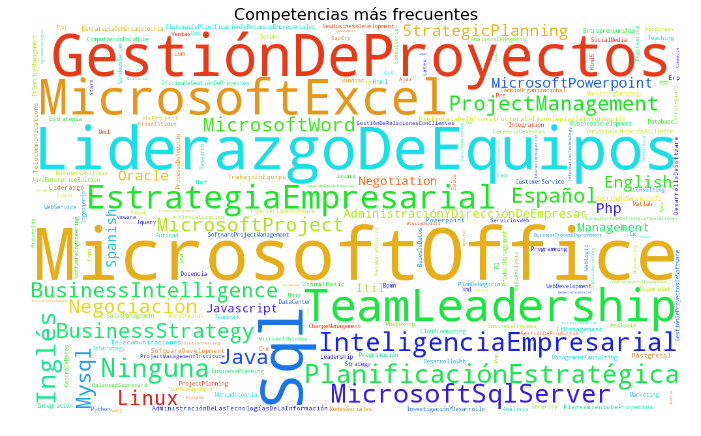

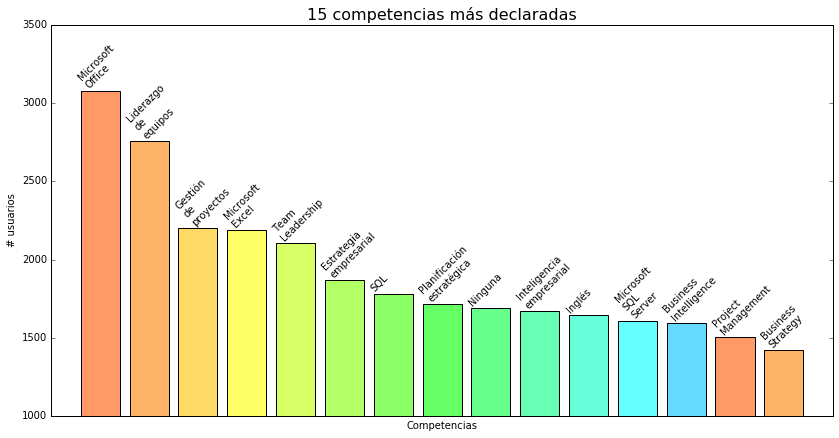

In [5]:
%matplotlib inline

# Graficar data: Nube de palabras y top n skills más frecuentes
# Requiere la herramienta word_cloud disponible desde https://github.com/amueller/word_cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Preprocesar skills para mostrarlas a partir de labels
text = " ".join([labels[i].title().replace(" ", "") for i in cols])
# Generar wordcloud
wordcloud = WordCloud(width=1000, height=600, background_color="white",
                      relative_scaling=0.1, prefer_horizontal=0.7).generate(text)
plt.figure(figsize=(14,7))
plt.title(u"Competencias más frecuentes", fontsize=16)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Contar frecuencia de skills y ordenar decreciente
nmax = 15
freq = np.bincount(cols)
s = np.argsort(freq)[::-1]
freq = freq[s]
plotlabels = np.array(labels)[s]
plotlabels = [label.replace(" ", "\n") for label in plotlabels]
colors = ['#ff9966','#ffb366','#ffd966','#ffff66','#d9ff66','#b3ff66','#8cff66','#66ff66','#66ff8c','#66ffb3', '#66ffd9', '#66ffff', '#66d9ff']
plt.figure(figsize=(14,7))
plt.title(str(nmax)+u' competencias más declaradas', fontsize=16)
rect = plt.bar(np.arange(nmax), freq[0:nmax], bottom=0, align="center", color=colors)
for i in range(nmax):
    plt.text(i-0.5, freq[i] , plotlabels[i], rotation=45, ha='left', va='bottom')
plt.ylabel("# usuarios")
plt.xlabel("Competencias")
plt.ylim([1000, 3500])
plt.xlim([-1,nmax])
plt.xticks([])
plt.show()

(d) Elija una competencia j ∈ {1, . . . , d} (por ejemplo PHP ). Su objetivo será predecir la existencia de
esta competencia en un perfil a partir de las demás competencias declaradas por el usuario. Con este
objetivo en mente, construya matrices X tr , y tr a partir de Z tr , definiendo y tr como la j-ésima columna
de Z tr y X tr como la matriz Z tr sin la j-ésima columna. Construya también las matrices X ts , y ts
análogamente a partir de Z ts .

In [9]:
def generate_sets(myskill):
    """
        Genera matrices de entrenamiento y de prueba para predecir
        la existencia o no en perfiles de la skill dada a través de
        remover la columna de datos indexada por la skill.
    """
    print "Skill elegida:",labels[myskill]
    print "Perfiles con esta skill en conjunto de entrenamiento:",len(np.nonzero(Ztr.toarray()[:,myskill])[0])
    print "Perfiles con esta skill en conjunto de prueba:",len(np.nonzero(Zts.toarray()[:,myskill])[0])

    # Generar data X e Y a partir de la data original
    Y = Z[:,myskill].toarray().T[0]
    X = csr_matrix(np.delete(Z.toarray(), myskill, 1))
    
    # Generar data de entrenamiento
    Ytr = Ztr[:,myskill].toarray().T[0]
    Xtr = csr_matrix(np.delete(Ztr.toarray(), myskill, 1))
    
    # Generar data de prueba
    Yts = Zts[:,myskill].toarray().T[0]
    Xts = csr_matrix(np.delete(Zts.toarray(), myskill, 1))
    return (Xtr, Ytr), (Xts, Yts)

In [22]:
(Xtr, Ytr), (Xts, Yts) = generate_sets(29)

Skill elegida: Microsoft Office
Perfiles con esta skill en conjunto de entrenamiento: 1841
Perfiles con esta skill en conjunto de prueba: 1240


(e) Entrene y evalúe al menos 5 clasificadores diferentes para el problema de predicción definido anteriormente. Compare los resultados obtenidos y discuta.

El primer clasificador a probar será regresión logística. Se realiza un fit y luego se muestra el score obtenido.

In [23]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1)
logreg.fit(Xtr, Ytr)
print "Score sobre conjunto de entrenamiento:",logreg.score(Xtr, Ytr)
print "Score sobre conjunto de prueba:",logreg.score(Xts, Yts)
print "Recall:",recall_score(logreg.predict(Xts), Yts)

Score sobre conjunto de entrenamiento: 0.944827586207
Score sobre conjunto de prueba: 0.819384615385
Recall: 0.785152838428


El segundo clasificador a probar será una SVM lineal con parámetro de regularización optimizado.

In [24]:
from sklearn.svm import LinearSVC
# Esta svm fue la mejor de un conjunto probado con distintos valores de regularización
svm = LinearSVC(C=0.00034)
svm.fit(Xtr.toarray(), Ytr)
print "Score sobre conjunto de entrenamiento:",svm.score(Xtr.toarray(), Ytr)
print "Score sobre conjunto de prueba:",svm.score(Xts.toarray(), Yts)
print "Recall:",recall_score(svm.predict(Xts), Yts)

Score sobre conjunto de entrenamiento: 0.832543103448
Score sobre conjunto de prueba: 0.830769230769
Recall: 0.831730769231


In [11]:
from sklearn.svm import SVC
# Default kernel: rbf
svm = SVC()
svm.fit(Xtr.toarray(), Ytr)
print "Score sobre conjunto de entrenamiento:",svm.score(Xtr.toarray(), Ytr)
print "Score sobre conjunto de prueba:",svm.score(Xts.toarray(), Yts)

Score sobre conjunto de entrenamiento: 0.611206896552
Score sobre conjunto de prueba: 0.626769230769


Tercer clasificador: Reducción de dimensionalidad con KernelPCA usando kernel lineal

In [41]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(kernel="cosine", fit_inverse_transform=True, gamma=10)
Xtr_kpca = kpca.fit_transform(Xtr.toarray())
Xts_kpca = kpca.transform(Xts.toarray())

In [43]:
svm = LinearSVC(C=1)
svm.fit(Xtr_kpca, Ytr)
print svm.score(Xtr_kpca, Ytr)
print svm.score(Xts_kpca, Yts)

0.93599137931
0.821846153846


In [42]:
logreg = LogisticRegression(C=1)
logreg.fit(Xtr_kpca, Ytr)
print logreg.score(Xtr_kpca, Ytr)
print logreg.score(Xts_kpca, Yts)

0.857112068966
0.834769230769


Cuarto clasificador: LDA

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(Xtr.toarray(), Ytr)

0.70153846153846156

In [25]:
print "Score sobre conjunto de entrenamiento:",lda.score(Xtr, Ytr)
print "Score sobre conjunto de entrenamiento:",lda.score(Xts, Yts)

Score sobre conjunto de entrenamiento: 0.987284482759
Score sobre conjunto de entrenamiento: 0.701538461538


Quinto clasificado: QDA

In [47]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(Xtr.toarray(), Ytr)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [48]:
print "Score sobre conjunto de entrenamiento:",qda.score(Xtr.toarray(), Ytr)
print "Score sobre conjunto de pruebas:",qda.score(Xts.toarray(), Yts)

Score sobre conjunto de entrenamiento: 0.956896551724
Score sobre conjunto de entrenamiento: 0.617230769231


Podemos ver que modelos más simple, con esta skill en especial, poseen mejor rendimiento sobre el conjunto de pruebas y además son más rápidos de entrenar. Regresión Logística y SVM lineal se llevan el premio a mejor rendimiento y tiempo de entrenamiento. Notar que para que la SVM lineal tuviera ese resultado hubo que ajustar su parámetro de regularización. Clasificadores más complejos tienden a demasiado overfitting, debido a sus complejas fronteras. Analizando el recall para las primeras máquinas, se observa que la SVM logra mejor resultados.

In [27]:
from sklearn.neighbors import KNeighborsClassifier
best = 0
best_score = 0
knn_models = []
for i in range(1, 10):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(Xtr, Ytr)
    knn_models.append(knn_model)
    score = knn_model.score(Xts, Yts)
    if score > best_score:
        best_score = score
        best = i
print "Score sobre el conjunto de entrenamiento con k=",best,":", knn_models[best-1].score(Xtr, Ytr)
print "Scobre sobre el conjunto de pruebas con k=",best,":",best_score

Score sobre el conjunto de entrenamiento con k= 9 : 0.840948275862
Scobre sobre el conjunto de pruebas con k= 9 : 0.805846153846


(f) Cambiando la skill por otra. En este caso se eligió al azar la skill 1300 que corresponde a "ATMs". Si uno revisa el conjunto total de datos, sólo 4 personas poseen esta skill. En el conjunto de entrenamiento uno de estos perfiles existe, mientras que en el conjunto de prueba los restantes 3 perfiles con esta skill existen.

In [15]:
(Xtr, Ytr), (Xts, Yts) = generate_sets(1300)

Skill elegida: ATMs
Perfiles con esta skill en conjunto de entrenamiento: 1
Perfiles con esta skill en conjunto de prueba: 3


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

logreg = LogisticRegression(C=1)
logreg.fit(Xtr, Ytr)
print "Score sobre conjunto de entrenamiento:",logreg.score(Xtr, Ytr)
print "Score sobre conjunto de prueba:",logreg.score(Xts, Yts)
print "Recall:",recall_score(logreg.predict(Xts), Yts)

Score sobre conjunto de entrenamiento: 1.0
Score sobre conjunto de prueba: 0.999076923077
Recall: 0.0


In [19]:
from sklearn.svm import LinearSVC
# Esta svm fue la mejor de un conjunto probado con distintos valores de regularización
svm = LinearSVC(C=0.00034)
svm.fit(Xtr.toarray(), Ytr)
print "Score sobre conjunto de entrenamiento:",svm.score(Xtr.toarray(), Ytr)
print "Score sobre conjunto de prueba:",svm.score(Xts.toarray(), Yts)
print "Recall:",recall_score(svm.predict(Xts), Yts)

Score sobre conjunto de entrenamiento: 0.999784482759
Score sobre conjunto de prueba: 0.999076923077
Recall: 0.0


In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(Xtr.toarray(), Ytr)
print "Score sobre conjunto de entrenamiento:",lda.score(Xtr, Ytr)
print "Score sobre conjunto de entrenamiento:",lda.score(Xts, Yts)
print "Recall:",recall_score(lda.predict(Xts), Yts)

/usr/lib64/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Score sobre conjunto de entrenamiento: 1.0
Score sobre conjunto de entrenamiento: 0.985846153846
Recall: 0.0


In [20]:
from sklearn.svm import SVC
# Default kernel: rbf
svm = SVC()
svm.fit(Xtr.toarray(), Ytr)
print "Score sobre conjunto de entrenamiento:",svm.score(Xtr.toarray(), Ytr)
print "Score sobre conjunto de prueba:",svm.score(Xts.toarray(), Yts)

Score sobre conjunto de entrenamiento: 0.999784482759
Score sobre conjunto de prueba: 0.999076923077


Podemos razonar que las skill de los perfiles que poseen "ATMs" son muy pocos, la probabilidad de obtener un resultado correcto adivinando al alzar es mejor que un clasificador. Nuevamente regresión logística y SVM poseen un excelente rendimiento, aunque la SVM lineal demora mucho menos en entrenar que su símil con kernel RBF. No obstante, si se analiza el recall para los casos, se puede observar que no estamos haciendo un mejor trabajo que adivinar, obteniendo recalls de 0%.

Ahora probamos con otra skill, "Geographic Information Science"

In [8]:
(Xtr, Ytr), (Xts, Yts) = generate_sets(13200)

Skill elegida: Geographic Information Science
Perfiles con esta skill en conjunto de entrenamiento: 0
Perfiles con esta skill en conjunto de prueba: 1


In [11]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1)
try:
    logreg.fit(Xtr, Ytr)
    print "Score sobre conjunto de entrenamiento:",logreg.score(Xtr, Ytr)
    print "Score sobre conjunto de prueba:",logreg.score(Xts, Yts)
except:
    print "No hay suficientes ejemplos en la data"

 No hay suficientes ejemplos en la data


En este caso la skill elegida lamentablemente tiene un solo ejemplo que ha quedado en el testing set, por lo que es imposible predecir sobre ella.